In [1]:
import pandas as pd
import json 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## load the json 
with open("user-wallet-transactions.json", 'r') as f:
    data=json.load(f)
df = pd.DataFrame(data)
df.head()    

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [3]:
df.shape

(100000, 13)

In [4]:
df.columns

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')

In [5]:
df['action'].value_counts()

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

In [6]:
df.isnull().sum()

_id            0
userWallet     0
network        0
protocol       0
txHash         0
logId          0
timestamp      0
blockNumber    0
action         0
actionData     0
__v            0
createdAt      0
updatedAt      0
dtype: int64

In [7]:
df['timestamp'].iloc[:5].values

array([1629178166, 1621525013, 1627118913, 1627773318, 1618845907],
      dtype=int64)

In [8]:
# convert timestamp to date-time
df['datetime']=pd.to_datetime(df['timestamp'],unit='s')
# EXTRACT AMOUNT 
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) / 1e18  if isinstance(x, dict) else 0)
df[['userWallet', 'action', 'amount', 'datetime']].head()

,userWallet,action,amount,datetime
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2.000000e-09,2021-08-17 05:29:26
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,1.450000e+02,2021-05-20 15:36:53
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,1.000000e-03,2021-07-24 09:28:33
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.000000e-03,2021-07-31 23:15:18
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.015480e-13,2021-04-19 15:25:07


In [9]:
df.groupby('action')['amount'].sum().sort_values(ascending=False)


action
deposit             2.199551e+08
borrow              1.689871e+08
redeemunderlying    1.610282e+08
repay               1.045092e+08
liquidationcall     0.000000e+00
Name: amount, dtype: float64

In [10]:
## Feature engineering 
# we will create wallet level  agg Fatures

In [11]:
# Prepare transaction-wise action summaries per wallet(pivot table )
action_pivot = df.pivot_table(
    index='userWallet',
    columns='action',
    values='amount',
    aggfunc='sum',
    fill_value=0
).reset_index()

# creating features for number of unique activity_days,first and lasst transactions,total transactions,
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['timestamp'].dt.date
## time based Feautures
wallet_time = df.groupby("userWallet").agg(
    first_tx=("timestamp", "min"),
    last_tx=("timestamp", "max"),
    tx_count=("timestamp", "count"),
    active_days=("date", "nunique")
).reset_index()
wallet_time["avg_tx_per_day"] = wallet_time["tx_count"] / wallet_time["active_days"]

# Step 3: Merge Everything Together
features_df = action_pivot.merge(wallet_time, on="userWallet", how="left")

# Step 4: Custom Net Position Feature
features_df["net_position"] = (
    features_df.get("deposit", 0) +
    features_df.get("repay", 0) -
    features_df.get("borrow", 0) -
    features_df.get("redeemUnderlying", 0)
)


In [12]:
#selectingg relavant features for models
model_features = features_df[[
    "deposit", "repay", "borrow", "liquidationcall",
    "net_position", "active_days", "avg_tx_per_day"
]]
#normalize 
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(model_features)
##applying k means to wallet segmentation into 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
features_df["cluster"] = kmeans.fit_predict(scaled_features)
# summarizing it per cluster
score_summary = features_df.groupby("cluster").agg({
    "deposit": "sum",
    "repay": "sum",
    "borrow": "sum",
    "liquidationcall": "sum",
    "net_position": "sum"
})
# define a custom metric to score clusters
score_summary["score_metric"] = (
    score_summary["deposit"] +
    score_summary["repay"] -
    score_summary["borrow"] -
    score_summary["liquidationcall"] +
    score_summary["net_position"]
).round(2)
#Rank clusters from best (1) to worst (5) based on score_metric
score_summary["rank"] = score_summary["score_metric"].rank(ascending=False, method='min').astype(int)
# Define fixed score for credit score  based on cluster rank
rank_to_score = {
    1: 1000,
    2: 750,
    3: 500,
    4: 250,
    5: 100
}
# map cluster to rank  and then assign crdit score 
cluster_to_rank = score_summary["rank"].to_dict()
features_df["credit_score_kmeans"] = features_df["cluster"].map(
    lambda c: rank_to_score[cluster_to_rank[c]]
)

wallet_scores = features_df[["userWallet", "credit_score_kmeans", "cluster"]]
wallet_scores.to_csv("wallet_credit_scores.csv", index=False)

print(wallet_scores.head())

                                   userWallet  credit_score_kmeans  cluster
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                  500        0
1  0x000000000051d07a4fb3bd10121a343d85818da6                  500        0
2  0x000000000096026fb41fc39f9875d164bd82e2dc                  500        0
3  0x0000000000e189dd664b9ab08a33c4839953852c                  500        0
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee                  250        3


In [13]:
print(features_df[["cluster", "credit_score_kmeans"]].value_counts().sort_index())
features_df["credit_score_kmeans"].value_counts().sort_index()

cluster  credit_score_kmeans
0        500                    2853
1        750                     169
2        1000                      2
3        250                      62
4        100                     411
Name: count, dtype: int64


credit_score_kmeans
100      411
250       62
500     2853
750      169
1000       2
Name: count, dtype: int64

In [14]:
features_df.columns

Index(['userWallet', 'borrow', 'deposit', 'liquidationcall',
       'redeemunderlying', 'repay', 'first_tx', 'last_tx', 'tx_count',
       'active_days', 'avg_tx_per_day', 'net_position', 'cluster',
       'credit_score_kmeans'],
      dtype='object')

In [15]:
print(features_df['cluster'].value_counts())


cluster
0    2853
4     411
1     169
3      62
2       2
Name: count, dtype: int64


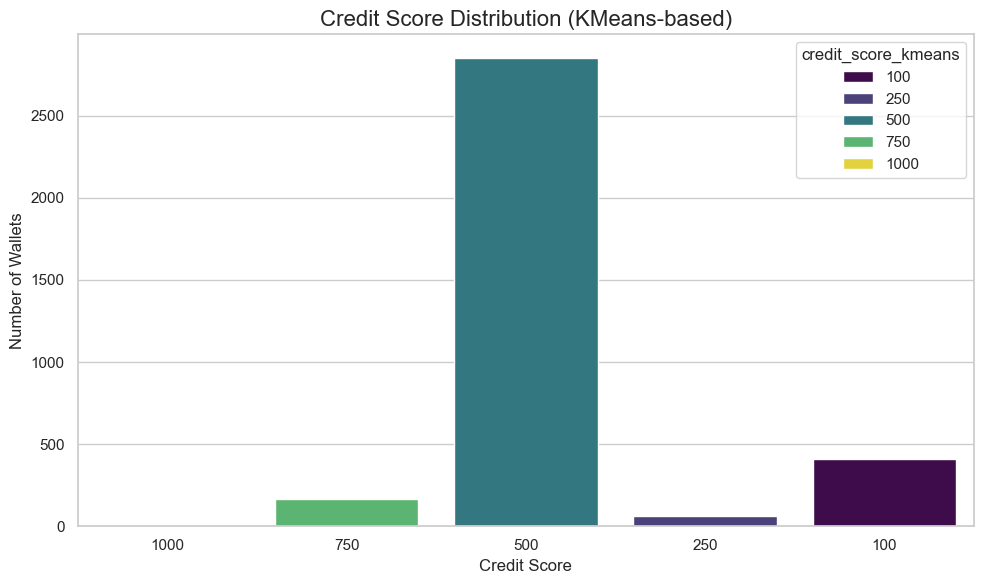

In [16]:

sns.set(style="whitegrid")
# Plot credit score distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=features_df,x='credit_score_kmeans',hue='credit_score_kmeans',palette='viridis',
              order=sorted(features_df['credit_score_kmeans'].unique(), reverse=True))
plt.title("Credit Score Distribution (KMeans-based)", fontsize=16)
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("credit_score_distribution.png", dpi=300)
plt.show()


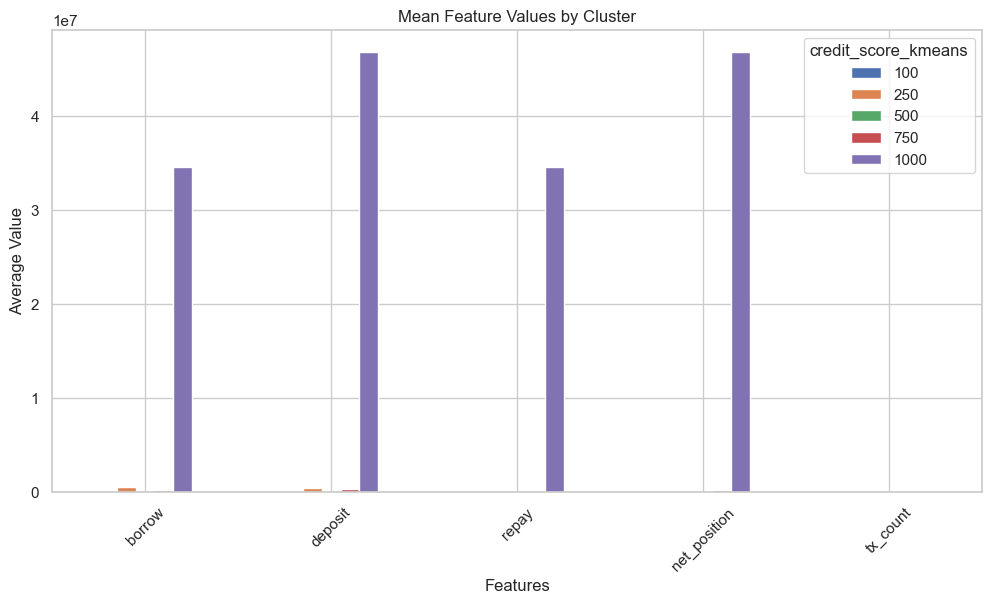

In [17]:
cluster_means = features_df.groupby('credit_score_kmeans')[['borrow', 'deposit', 'repay', 'net_position', 'tx_count']].mean()
cluster_means.T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Feature Values by Cluster')
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("mean_feature.png", dpi=300)
plt.show()